INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


5000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE = 74.6533646903273%
SMAPE = 14.045930147738515%
10000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE = 206.80094201770186%
SMAPE = 21.80075034606088%
15000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 300.98914359276466%
SMAPE = 26.260891602513937%
20000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 85.18048244991026%
SMAPE = 14.04283668130989%
25000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 70.41023153212225%
SMAPE = 15.658732475878853%
30000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 94.04912665402344%
SMAPE = 14.924345775529876%
35000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 150.0947529605518%
SMAPE = 17.533266230229877%


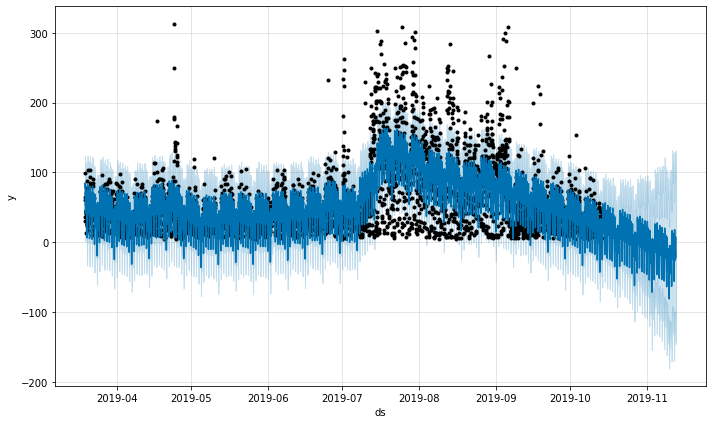

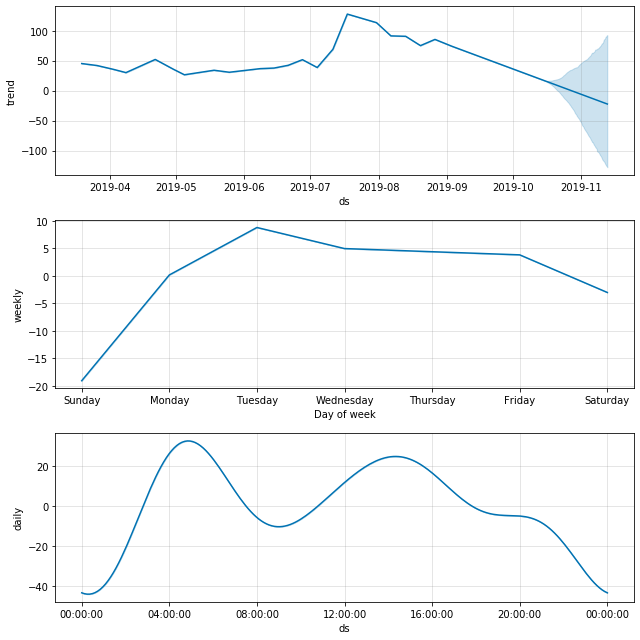

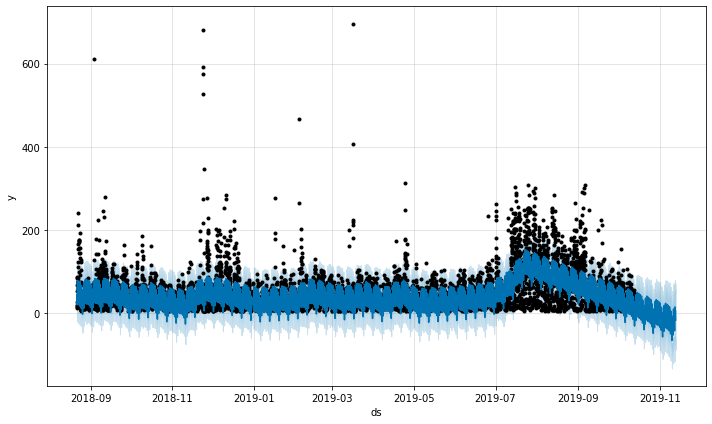

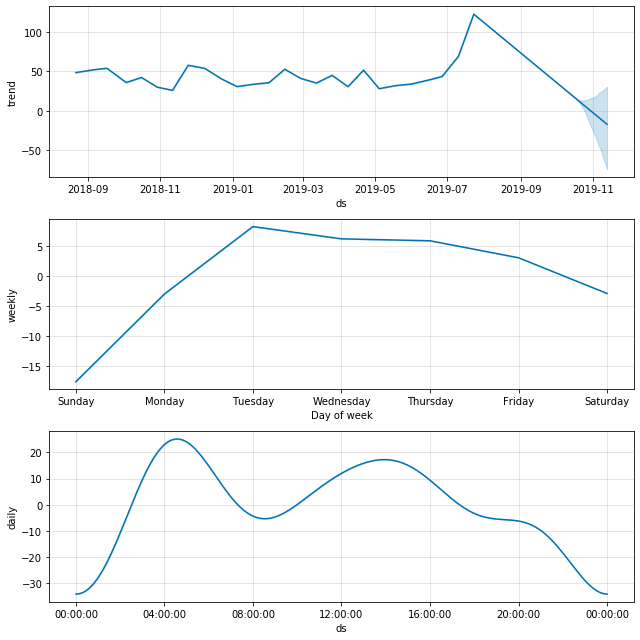

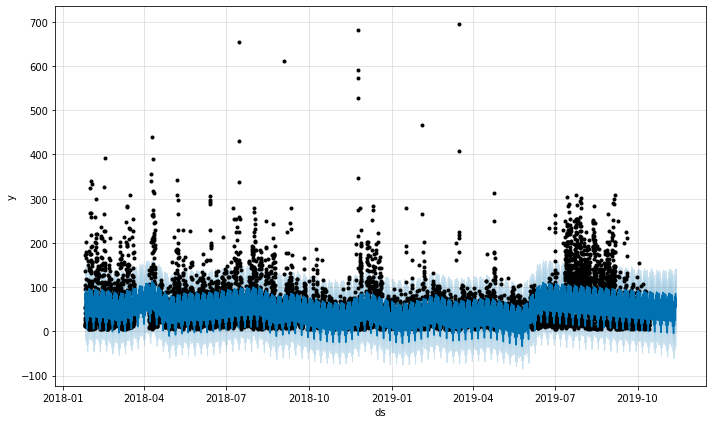

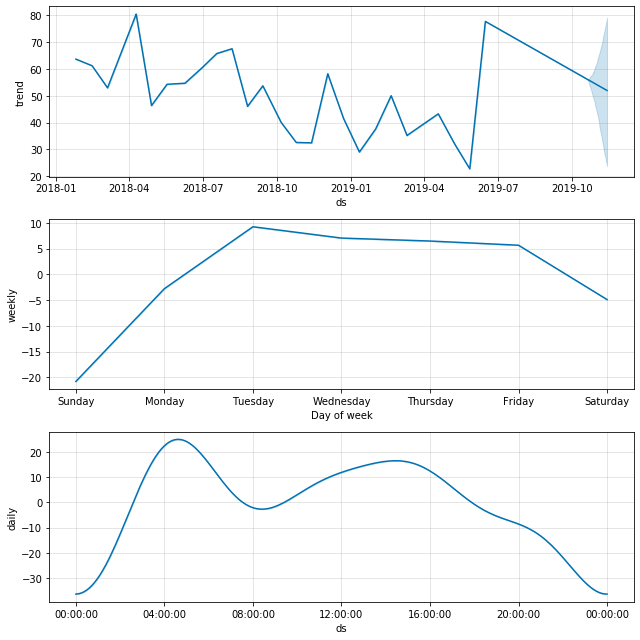

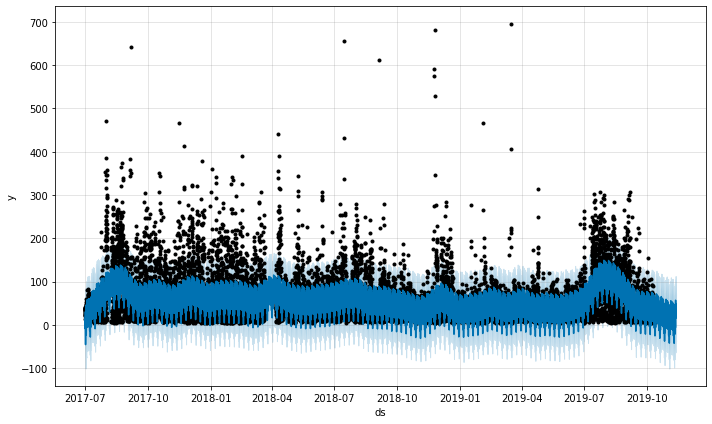

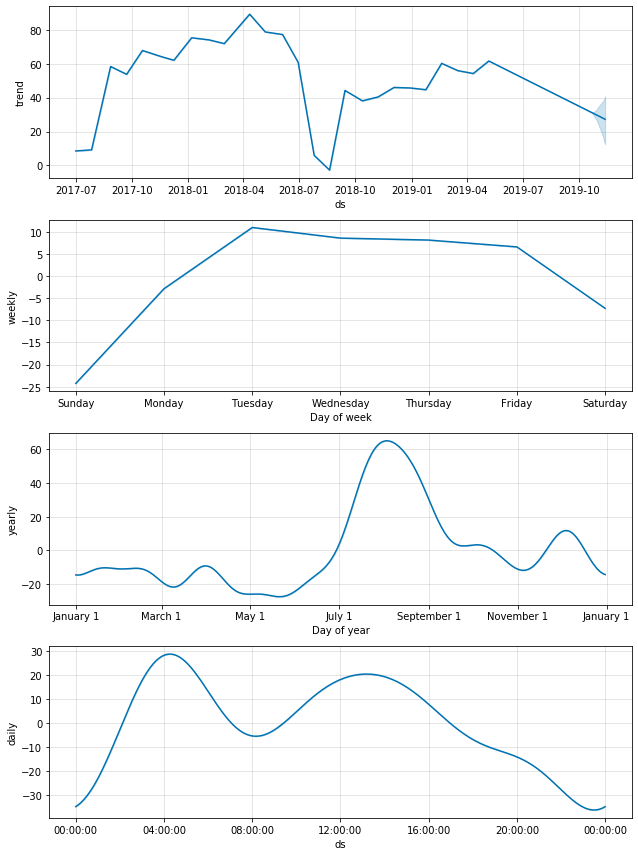

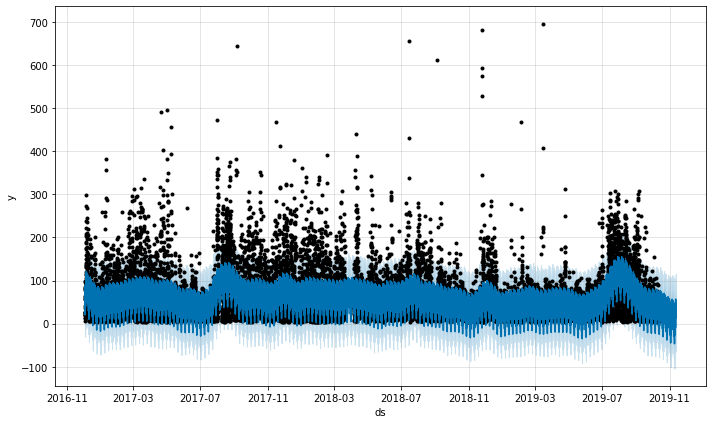

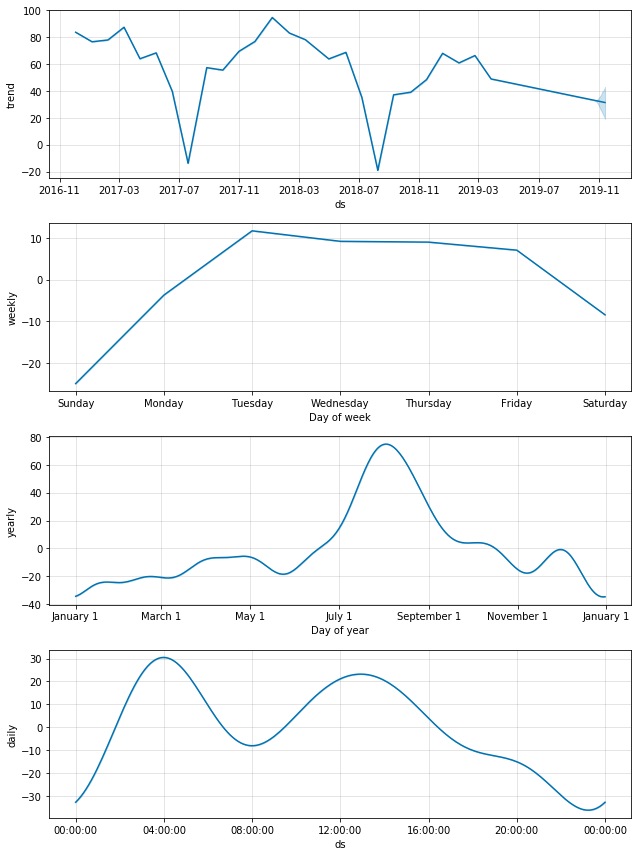

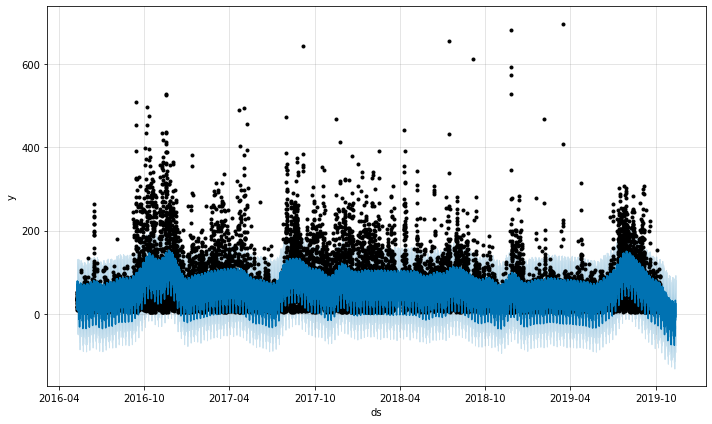

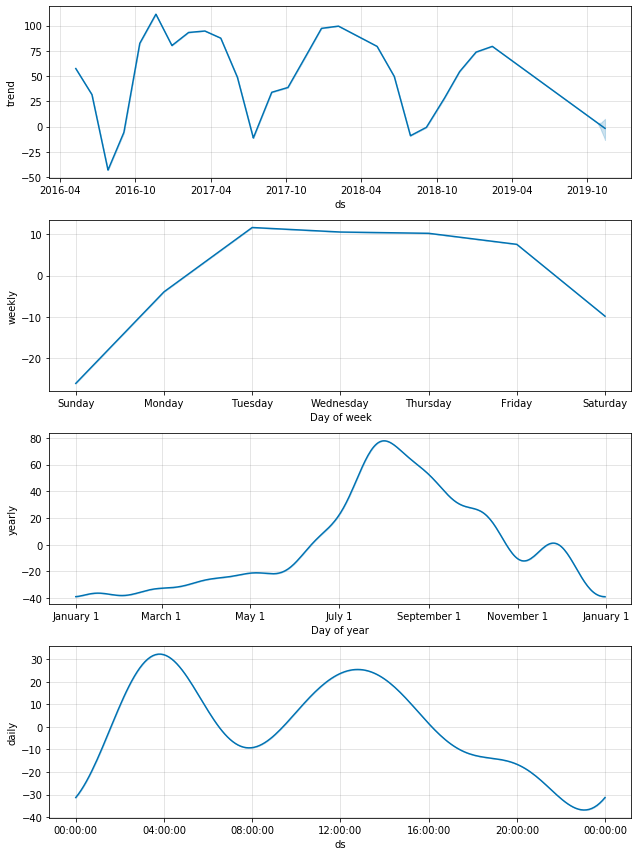

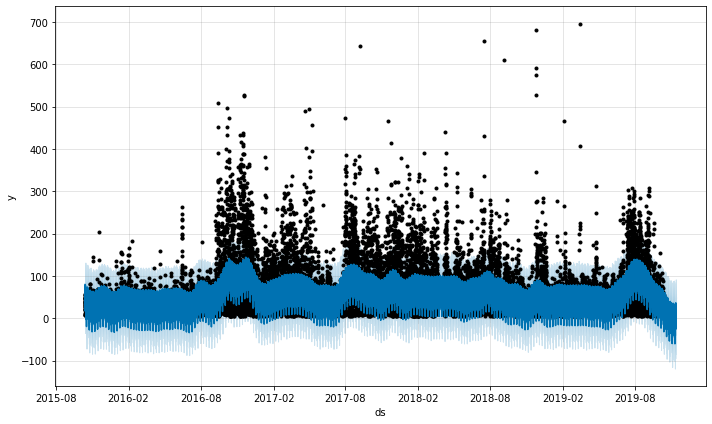

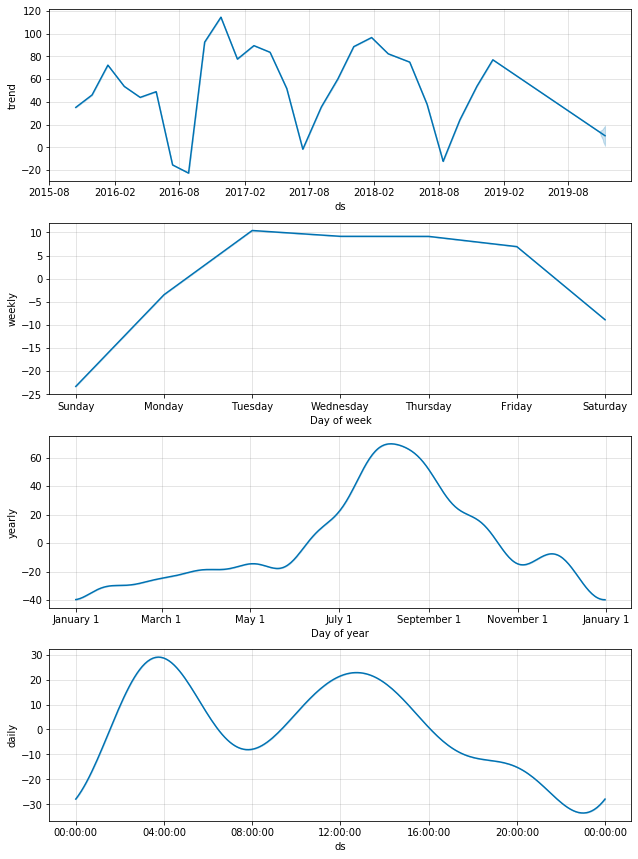

In [7]:
# load JSON
import json
import pandas as pd
import numpy as np

SMAPE_arr = []
nSampleArr = [5000,10000,15000,20000,25000,30000,35000]

for i in nSampleArr:
    
    print(i)
    n_samples = i
    
    # hourly data 
    data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
    data = data.sort_values(by=['ds'])
    data['just_date'] = data['ds'].dt.date
    temp = data.iloc[-1,:]
    firstDate = temp['just_date']

    t_start = len(data) - n_samples
    df_h = data[t_start:(t_start+n_samples)]

    import matplotlib.pyplot as plt
    #pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    #plt.figure(figsize=(15,3))
    #plt.plot(df_h['ds'],df_h['y'])
    #plt.title('by hour')

    df = df_h # select daily or hourly daya
    n_prd = 720

    from fbprophet import Prophet

    m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
    m.fit(df)
    future = m.make_future_dataframe(periods=n_prd, freq='H')
    forecast = m.predict(future)
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    fig = m.plot(forecast)
    components_fig = m.plot_components(forecast)

    #from fbprophet.plot import add_changepoints_to_plot
    #fig = m.plot(forecast)
    #a = add_changepoints_to_plot(fig.gca(), m, forecast)

    # PROPHET validation
    from fbprophet.diagnostics import cross_validation
    horInt = int(180*i/45000)
    df_cv = cross_validation(m, initial = str(int(i/24-30)) + ' days', period = '180 days', horizon = '30 days')
                             #horizon = str(horInt) + ' days') # horizon: forecast ; initial: training (default: 3x horizon); 
    df_cv.head()

    # Performance metrics
    from fbprophet.diagnostics import performance_metrics
    df_p = performance_metrics(df_cv)
    #df_p.head()

    # mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
    # computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
    # By default, 10% of the predictions in each window (can be changed) 
    # high rollingwindow --> smoother average curve 

    # Visualize cross-validation
    #from fbprophet.plot import plot_cross_validation_metric
    #fig = plot_cross_validation_metric(df_cv, metric='mape')

    # Percentage errors
    mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
    smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
    print('MAPE = ' + str(mape) + '%')
    print('SMAPE = ' + str(smape) + '%')
    SMAPE_arr.append(smape)
    

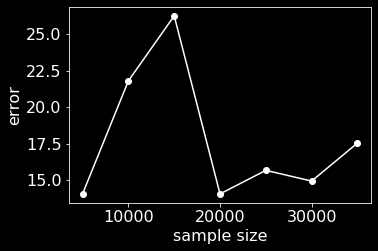

In [8]:
import matplotlib.pyplot as plt
import matplotlib
#nSampleArr = [5000,10000,15000,20000,25000,30000,35000,40000,45000]
#SMAPE_arr = [16.373516664976982,15.719684311746171,15.86214989569724,31.42764857564813,
#             30.92083567678546,26.024153701193807,26.13924119454204,31.483085441655838,
#             25.276699347639937]
font = {'size': 16,             # font setting
       'weight':'normal'}       # font setting
matplotlib.rc('font', **font)   # font setting
plt.style.use('dark_background') # this turns the whole figure (and following figures) into dark mode
plt.plot(nSampleArr,SMAPE_arr,'o-w')
plt.xlabel('sample size')
plt.ylabel('error')
plt.gcf().subplots_adjust(bottom=0.2,left=0.2)
plt.savefig('pickleToData_PROPHET_hourly_samplesize.png',transparent=True) # this turns the printed background transparent

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


5000


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-09-13 19:00:00 and 2019-09-13 19:00:00


MAPE = 74.6533646903273%
SMAPE = 14.045930147738515%
*** Data Saved ***


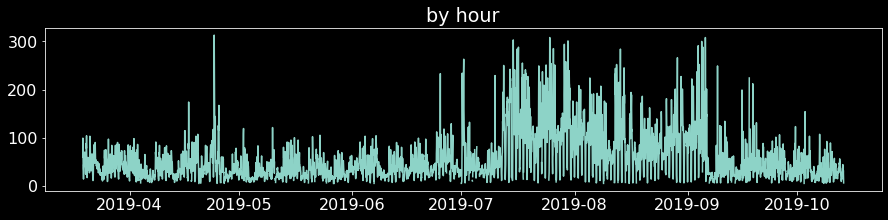

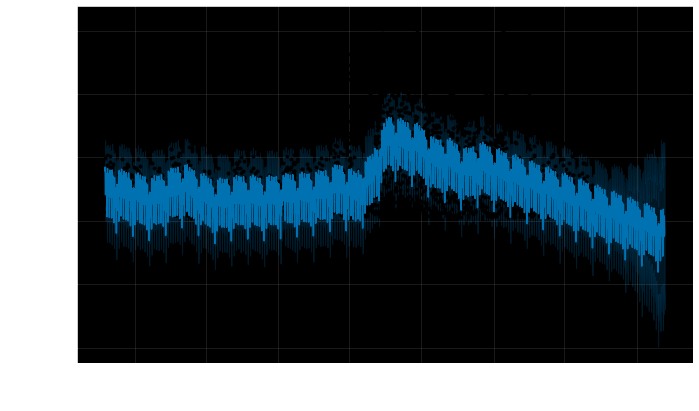

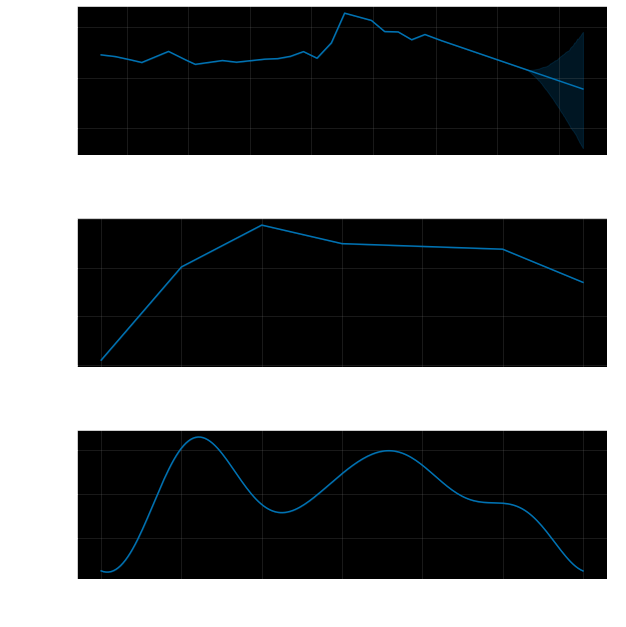

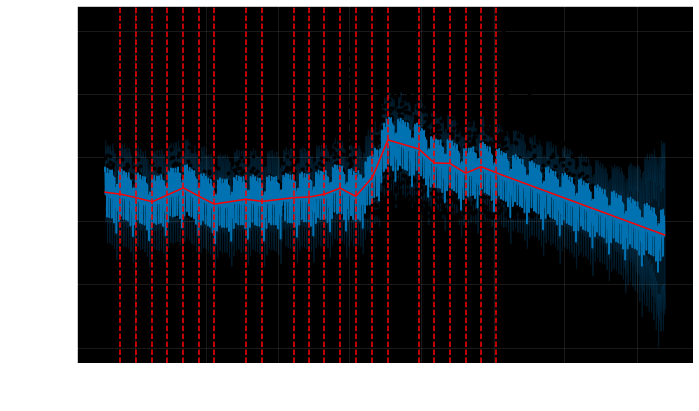

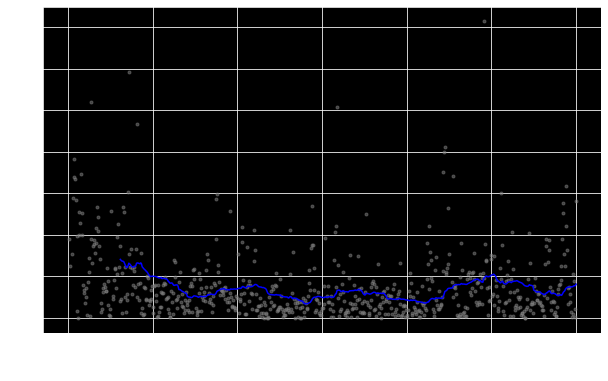

In [9]:
# load JSON
import json
import pandas as pd
import numpy as np

SMAPE_arr = []
nSampleArr = [5000]

for i in nSampleArr:
    
    print(i)
    n_samples = i
    
    # hourly data 
    data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
    data = data.sort_values(by=['ds'])
    data['just_date'] = data['ds'].dt.date
    temp = data.iloc[-1,:]
    firstDate = temp['just_date']

    t_start = len(data) - n_samples
    df_h = data[t_start:(t_start+n_samples)]

    import matplotlib.pyplot as plt
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    plt.figure(figsize=(15,3))
    plt.plot(df_h['ds'],df_h['y'])
    plt.title('by hour')

    df = df_h # select daily or hourly daya
    n_prd = 720

    from fbprophet import Prophet

    m = Prophet(changepoint_prior_scale=1) #  Increasing scale will make the trend more flexible:
    m.fit(df)
    future = m.make_future_dataframe(periods=n_prd, freq='H')
    forecast = m.predict(future)
    pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
    fig = m.plot(forecast)
    components_fig = m.plot_components(forecast)

    from fbprophet.plot import add_changepoints_to_plot
    fig = m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)

    # PROPHET validation
    from fbprophet.diagnostics import cross_validation
    df_cv = cross_validation(m, initial = str(int(i/24-30)) + ' days', period = '180 days', horizon = '30 days') # horizon: forecast ; initial: training (default: 3x horizon); 
    df_cv.head()

    # Performance metrics
    from fbprophet.diagnostics import performance_metrics
    df_p = performance_metrics(df_cv)
    df_p.head()

    # mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
    # computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
    # By default, 10% of the predictions in each window (can be changed) 
    # high rollingwindow --> smoother average curve 

    # Visualize cross-validation
    from fbprophet.plot import plot_cross_validation_metric
    fig = plot_cross_validation_metric(df_cv, metric='mape')

    # Percentage errors
    mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
    smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
    print('MAPE = ' + str(mape) + '%')
    print('SMAPE = ' + str(smape) + '%')
    SMAPE_arr.append(smape)
    
import pickle
pkl_path = "franklin-d-roosevelt/PM10_hourly_m.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("franklin-d-roosevelt/PM10_hourly_forecast.pkl")
print("*** Data Saved ***")